In [1]:
using Pkg
Pkg.activate("project_env")
Pkg.instantiate()

  Activating project at `c:\Files\Code\SIRCode\project_env`


## function setup

In [44]:
"""Dynamic message-passing on SIR model, proposed in
Andrey Y. Lokhov et al., Phys. Rev. E 91, 012811, 2015.

At initial time, a node i is in state I with probability PI[i] = σ0[i],
while it is in state S with probability PS[i] = 1 - σ0[i].

Optimization of the SIR model by back-propagation and gradient ascent:
-> Consider σ0 as the decision variables.
-> The objective is to select the initial seed to influence the positive targeted nodes,
   while trying to avoid influencing the negative targeted nodes.

-- Bo Li
"""

using DataFrames
using CSV
using Graphs
using SparseArrays
using Random
using ReverseDiff

include("GraphUtil.jl")
# using .GraphUtil


function softmax(h)
    """Softmax function.
    The input h should be a 1d vector."""
    hmax = maximum(h)
    Ph = exp.( h .- hmax )
    Ph = Ph ./ sum(Ph)
    return Ph
end


function inverse_softmax(Ph)
    """Inverse softmax function.
    The input Ph should be a 1d vector, satisfying sum(Ph)=1, 0 < Ph[i] < 1.
    Note that Ph[i] cannot be equal to 0 or 1."""
    h = log.(Ph)   ## generally h = log.(Ph) + c, where c is an arbitrary constant
    return h
end


function dynamic_MP(T, edge_list, adj_mat, adj_n, deg, σ0, βv, μ, opt)
    """Dynamic message passing.

    βv is a vector containing the infection probabilities with βv[e] = β[i, j],
    where the e-th edge is (i, j).

    opt is a string indicating which variables are the control variables; this is important
    as the type of the control variables need to propagate to the dynamical variables
    for the effectiveness of autodiff."""

    if opt == "beta"
        type_of_var = eltype(βv)
    elseif opt == "mu"
        type_of_var = eltype(μ)
    elseif opt == "sigma0"
        type_of_var = eltype(σ0)
    end

    no_of_nodes = size(adj_mat, 1)
    no_of_edges = size(edge_list, 1)

    β = spzeros(eltype(βv), size(adj_mat)...)   ## N X N sparse matrix

    for e in 1:no_of_edges
        i, j = edge_list[e, :]
        β[i, j] = βv[e]
        β[j, i] = βv[e]
    end

    PS = [spzeros(type_of_var, size(adj_mat)...) for t in 1:T+1]
    θ =  [spzeros(type_of_var, size(adj_mat)...) for t in 1:T+1]
    ϕ =  [spzeros(type_of_var, size(adj_mat)...) for t in 1:T+1]

    ## Initial condition:
    for i in 1:no_of_nodes
        for n in 1:deg[i]
            j = adj_n[i, n]
            θ[1][i, j] = 1.
            ϕ[1][i, j] = σ0[i]
            PS[1][i, j] = (1 - σ0[i])
        end
    end

    for t in 2:T+1
        for i in 1:no_of_nodes
            for n in 1:deg[i]
                j = adj_n[i, n]
                temp = 1.
                for m in 1:deg[i]
                    k = adj_n[i, m]
                    if k == j
                        continue
                    end
                    θ[t][k, i] = θ[t-1][k, i] - β[k, i] * ϕ[t-1][k, i]
                    temp *= θ[t][k, i]
                end
                PS[t][i, j] = (1 - σ0[i]) * temp
                ϕ[t][i, j] = (1 - β[i, j] - μ[i] + β[i, j]*μ[i]) * ϕ[t-1][i, j] -
                                (PS[t][i, j] - PS[t-1][i, j])
                θ[t][i, j] = θ[t-1][i, j] - β[i, j] * ϕ[t-1][i, j]
            end
        end
    end

    return PS, θ, ϕ
end


function DMP_marginal(T, adj_mat, adj_n, deg, σ0, βv, μ, PS, θ, ϕ, opt)
    """Marginal probability of DMP.

    'opt' is a string indicating which variables are the control variables; this is important
    as the type of the control variables need to propagate to the dynamical variables
    for the effectiveness of autodiff."""

    if opt == "beta"
        type_of_var = eltype(βv)
    elseif opt == "mu"
        type_of_var = eltype(μ)
    elseif opt == "sigma0"
        type_of_var = eltype(σ0)
    end

    no_of_nodes = size(adj_mat, 1)

    PS_mgn = zeros(type_of_var, T+1, no_of_nodes)
    PI_mgn = zeros(type_of_var, T+1, no_of_nodes)
    PR_mgn = zeros(type_of_var, T+1, no_of_nodes)

    ## Initial condition:
    for i in 1:no_of_nodes
        PS_mgn[1, i] = 1 - σ0[i]
        PI_mgn[1, i] = σ0[i]
        PR_mgn[1, i] = 0
    end

    for t in 2:T+1
        for i in 1:no_of_nodes
            temp = 1.
            for m in 1:deg[i]
                k = adj_n[i, m]
                temp *= θ[t][k, i]
            end
            PS_mgn[t, i] = (1 - σ0[i]) * temp
            PR_mgn[t, i] = PR_mgn[t-1, i] + μ[i] * PI_mgn[t-1, i]
            PI_mgn[t, i] = 1 - PS_mgn[t, i] - PR_mgn[t, i]
        end
    end

    return PS_mgn, PI_mgn, PR_mgn
end


function forward_obj_func(T, edge_list, adj_mat, adj_n, deg, σ0, βv, μ, opt,
            λ, PTargets, NTargets)
    """Objective function governed by the forward equations.
    PTargets: the set of nodes to be influenced.
    NTargets: the set of nodes Not to be influenced."""
    PS, θ, ϕ = dynamic_MP(T, edge_list, adj_mat, adj_n, deg, σ0, βv, μ, opt)
    PS_mgn, PI_mgn, PR_mgn =
        DMP_marginal(T, adj_mat, adj_n, deg, σ0, βv, μ, PS, θ, ϕ, opt)

    obj = sum( 1 .- PS_mgn[T+1, ] )
    return obj
end


function gradient_descent_over_σ0_multiseed(edge_list, adj_mat, adj_n, deg, σtot, T, βv, μ,
            λ, PTargets, NTargets)
    """Gradient descent over initial seed σ0[i], assuming sum(σ0) = σtot.

    In this experiment, a reparameterization method is use to enforce the constraint
        sum(σ0) = σtot, 0 < σ0[i], as use in [Saad and Lokhov PNAS2017],
    i.e., we let σ0[i] = σtot* exp(h0[i]) / (sum( exp.(h0) )), i.e., σ0 = σtot * softmax(h0).

    A barrier function ϵ*log(1 - σ0[i]) is used to deal with the upper bound constraint of σ0[i] < 1.
    """
    ## Setting the parameters:
    no_of_nodes = size(adj_mat, 1)
    no_of_edges = size(edge_list, 1)

    # σ0 = ones(no_of_nodes) / no_of_nodes * σtot
    Random.seed!(100)
    σ0 = rand(no_of_nodes)
    σ0 *= σtot / sum(σ0)

    h0 = inverse_softmax(σ0 / σtot)

    ## Augmented objective function: L = objf + ϵ * ∑_i log(1 - σ0[i]), as a function of h0
    ϵ = 0.02
    L_of_h0 = x -> forward_obj_func(T, edge_list, adj_mat, adj_n, deg, softmax(x)*σtot, βv, μ, "sigma0", λ, PTargets, NTargets) +
                   ϵ * sum( log.( 1 .- softmax(x)*σtot ) )

    o1 = forward_obj_func(T, edge_list, adj_mat, adj_n, deg, softmax(h0)*σtot, βv, μ, "sigma0", λ, PTargets, NTargets)
    L = L_of_h0(h0)

    ## Perform gradient ascent:
    for step in 1:60
        ∇L = ReverseDiff.gradient(L_of_h0, h0)

        ## Backtracking line search:
        α, γ = 0.3, 0.6     ## parameters for line search
        s = 20.             ## initial guess of step size
        L_temp = 0.
        for inner_step in 1:20
            h0_temp = h0 + s*∇L
            σ0_temp = softmax(h0_temp) * σtot
            if maximum(σ0_temp) >= 1    ## To ensure σ0[i] < 1
                s *= γ
                continue
            end

            L_temp = L_of_h0(h0 + s*∇L)
            if L_temp > L + α*s* sum( ∇L .^ 2 )
                L = L_temp
                break
            else
                s *= γ
            end
        end

        h0 += s*∇L
        σ0 = softmax(h0) * σtot
        ∇L_norm = sum(∇L .^ 2)
        println("At step = $(step), s = $(s), min_σ0 = $(minimum(σ0)), max_σ0 = $(maximum(σ0)), |∇L|^2 = $(∇L_norm), L = $(L_temp).")

        if ∇L_norm < 1e-6
            break
        end

    end

    o2 = forward_obj_func(T, edge_list, adj_mat, adj_n, deg, softmax(h0)*σtot, βv, μ, "sigma0", λ, PTargets, NTargets)

    println("\n")
    println("minimum and maximum of σ0: $(minimum(σ0)), $(maximum(σ0))\n")
    println("sum σ0 before and after optimization: $(σtot), $(sum(σ0))\n")
    println("obj before and after optimization: $(o1), $(o2)\n")

    return o1, o2, σ0
end


function round_up_σ0(σ0, σtot::Int)
    """Pick the nodes with highest value of σ0 as initial seeds."""
    ind = sortperm(σ0, rev=true)
    set_of_seeds = ind[1:σtot]
    σ0_soln = zeros(length(σ0))
    σ0_soln[ set_of_seeds ] .= 1         ## set the σ0 value of the seeding nodes to be 1
    return set_of_seeds, σ0_soln
end

round_up_σ0 (generic function with 1 method)

## main

In [70]:
## Directory to dump results:
dir_result = "./results/"

## Artificial networks:
dir_network = "./artificial_networks/"
# graph_name = "bt_depth6"                ## DMP should be exact on tree networks
# graph_name = "star6"
graph_name = "ER_N100_d5_seed102"
# graph_name = "rrg_N100_d5_seed100"


node_data, edge_data, graph = GraphUtil.read_graph_from_csv(dir_network * graph_name, false)   # an un-directed graph
if !is_connected(graph)
    println("The base graph is not connected.")
end
max_deg, deg, edge_list, edge_indx, adj_n, adj_e, adj_e_indx, adj_mat, B = GraphUtil.undigraph_repr(graph, edge_data)

no_of_nodes = size(adj_mat, 1)
no_of_edges = size(edge_list, 1)

@time begin

## Problem parameters:
βmag = 0.2
μmag = 1.
βv = ones(Float64, no_of_edges) * βmag
μ = ones(Float64, no_of_nodes) * μmag

T = 20

λ = 1.

## All nodes to be influenced:
# PTargets = collect(1:nv(graph))
# NTargets = []

## Randomly pick some nodes to be influenced (PTargets), and some other nodes NOT to be influenced (NTargets):
Random.seed!(110)
ind = randperm( nv(graph) )
PTargets = ind[1:50]
NTargets = ind[51:100]

σtot = 5
o1, o2, σ0 = gradient_descent_over_σ0_multiseed(edge_list, adj_mat, adj_n, deg, σtot, T, βv, μ, λ, PTargets, NTargets)
set_of_seeds, σ0_soln = round_up_σ0(σ0, σtot)

o3 = forward_obj_func(T, edge_list, adj_mat, adj_n, deg, σ0_soln, βv, μ, "sigma0", λ, PTargets, NTargets)
println("obj after round up: $(o3)\n")

## Trajectories based on σ0_soln:
PS, θ, ϕ = dynamic_MP(T, edge_list, adj_mat, adj_n, deg, σ0_soln, βv, μ, "sigma0")
PS_mgn, PI_mgn, PR_mgn =
    DMP_marginal(T, adj_mat, adj_n, deg, σ0_soln, βv, μ, PS, θ, ϕ, "sigma0")

## save the solution:
node_types = zeros(Int, no_of_nodes)
node_types[PTargets] .= 1
node_types[NTargets] .= -1
open(dir_result * "sigma0_" * graph_name * ".csv", "w") do io
    write(io, "node_id,node_type,σ0,σ0_rounded,P_S\n")
    for i in 1:no_of_nodes
        write(io, "$i,$(node_types[i]),$(σ0[i]),$(σ0_soln[i]),$(PS_mgn[T+1,i])\n")
    end
end

end  ## end of @time

At step = 1, s = 20.0, min_σ0 = 0.0007887345546393053, max_σ0 = 0.10602770022310132, |∇L|^2 = 0.0009679365324750127, L = 0.37227027711227434.
At step = 2, s = 20.0, min_σ0 = 0.0007782354767120154, max_σ0 = 0.19352745112114195, |∇L|^2 = 0.002251510472152749, L = 0.4396742466634389.
At step = 3, s = 12.0, min_σ0 = 0.0007208280415704943, max_σ0 = 0.6109697697750667, |∇L|^2 = 0.010783783441717834, L = 0.6688168380004145.
At step = 4, s = 1.5551999999999997, min_σ0 = 0.0006778674306641646, max_σ0 = 0.896455026907333, |∇L|^2 = 0.08289647368653745, L = 0.8106638038688012.
At step = 5, s = 0.33592319999999987, min_σ0 = 0.0006661376388367831, max_σ0 = 0.9727818877020682, |∇L|^2 = 0.08829168280073199, L = 0.8294039549016777.
At step = 6, s = 0.07255941119999997, min_σ0 = 0.000667095117680505, max_σ0 = 0.9665724079393144, |∇L|^2 = 0.011827774823705598, L = 0.8298079779445516.
At step = 7, s = 0.12093235199999994, min_σ0 = 0.0006671136313364262, max_σ0 = 0.9664538927237978, |∇L|^2 = 1.771450947895

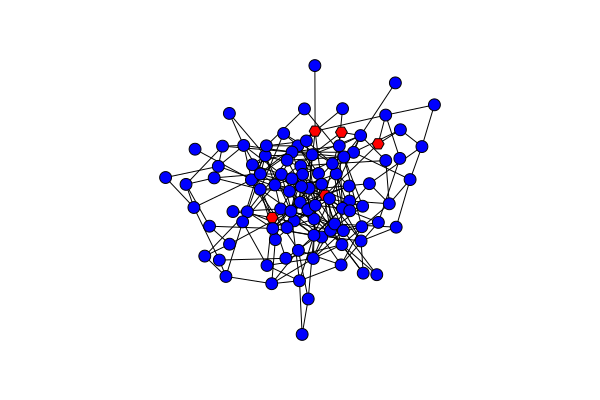

In [ ]:
using Plots, GraphRecipes, Colors

# 1. Compute final infection probability for each node
#    (PS_mgn is indexed as PS_mgn[time, node])
final_inf_prob = 1 .- PS_mgn[end, :]

# 2. Mark which nodes are seeds
seed_set = Set(set_of_seeds)

# 3. Build a shape array: star for seeds, circle for others
shapes = [i in seed_set ? :hexagon : :circle for i in 1:nv(graph)]

# 4. Build a color array with alpha = final_inf_prob
#    Seeds in solid red, others in semi‐transparent blue
node_colors = [
    i in seed_set ? RGBA(1,0,0,1.0) : RGBA(0,0,1, clamp(final_inf_prob[i], 0, 1))
    for i in 1:nv(graph)
]

# 5. Plot with a spring layout, no edge‐curving, gray edges
graphplot(
    graph;
    nodeshape = shapes,
    nodecolor  = node_colors,
    nodesize   = 0.2,
    method     = :spring,
    curves     = false,
    linecolor  = :gray,
    # names      = 1:nv(graph),    # label nodes by index
    # fontsize   = 8,
    # legend     = false
)
